# Ofset free MPC using matric C

In [67]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [68]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('./data/A_C_' + str(matrix_C) + '.npy')
B = np.load('./data/B_C_' + str(matrix_C) + '.npy')
C = np.load('./data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [69]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [70]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [71]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [72]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [73]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## Optimal control problem

Observer - Kalman filter

In [ ]:
y_start = np.array([0.5, 0.5])
y_start = scaler.transform(y_start.reshape(1, -1))

y_setpoint = np.array([1.5, 0.8])
y_setpoint = scaler.transform(y_setpoint.reshape(1, -1))[0]

u_previous = np.array([0.2, 0.5])
u_previous = scalerU.transform(u_previous.reshape(1, -1))[0]

sim_time = 100

z_est_ = np.hstack((get_x(y_start).T, np.zeros((1,nd))))
P0 = np.eye(nz+nd) * 0.1

# Noise covariances
Q = np.eye(nz+nd) * 0.1  # process noise
R = np.eye(ny) * 0.5  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

EKF = helper.EKF(A_,B_,z_est_,P0, problem, Q, R, 2)


Target calculation

In [75]:
N = 20
Qy = np.eye(ny) * 20
Qu = np.eye(nu)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(get_x(y_start).T[0]).float(),
)

C_k = cp.Parameter((ny, nz))
C_k.value = J


# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
d0 = cp.Parameter(ny)
d0.value = np.zeros(ny)
u_prev = cp.Parameter(nu)

y_sp = cp.Parameter(ny)
y_sp.value = y_setpoint
# y_sp = y_setpoint
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N+1))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 
z_s = cp.Variable(nz)
z_k = cp.Parameter(nz)
z_k.value = z_est_[0,:nz]
y_k = cp.Parameter(ny)
y_k.value = get_y(z_k.value)[0]
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)


In [76]:
get_y(z_k.value)

array([[-0.8223318 , -0.61554295]], dtype=float32)

In [77]:
y_setpoint

array([ 0.30112528, -0.2191349 ])

In [78]:
(y_k - C_k@z_k).value

array([-0.33789648, -0.29039267])

In [79]:

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C_k @ z_s + y_k - C_k @ z_k + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))
print("Desired y:", scaler.inverse_transform(y_sp.value.reshape(1,-1)))
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.4256813  0.84398389]]
Desired y: [[1.5 0.8]]
Optimal u: [[0.5        0.30187154]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [80]:

C_k.value = J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_s.value).float(),
)
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C_k @ z_s + y_k - C_k @ z_k + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))
print("Desired y:", scaler.inverse_transform(y_sp.value.reshape(1,-1)))
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.5 0.8]]
Desired y: [[1.5 0.8]]
Optimal u: [[0.3504034 0.3148469]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [81]:
y_s.value - y_sp.value

array([-2.44227594e-09,  2.88231061e-09])

MPC problem formulation


In [82]:
z0.value = z_est_[0,0:nz]
u_prev.value = u_previous

In [83]:
C_k.value = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_s.value).float(),
)
J = C_k.value
Qz = J.T@Qy@J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        #y[:, k] == C @ z[:, k] + F @ d0,
        y[:, k] == C_k @ z[:, k] + y_k - C_k @ z_k + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

In [84]:
def construct_MPC(J_k):
    J = J_k
    Qz = J.T@Qy@J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    # Constraints and cost
    cost = 0
    for k in range(N):    
        cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)
    mpc = cp.Problem(cp.Minimize(cost), constraints)
    return mpc
    # Terminal cost - not yet
    # cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [85]:
# sanity check and problem formulation
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[1.76914395 0.05828646]
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [86]:


sim_time = 150
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
us_sim = np.zeros((nu, sim_time+1))

y_sp.value = scaler.transform(np.array([[0.5,0.5]]))[0]
target_estimation.solve(solver=cp.GUROBI)
z_ref.value = z_s.value

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]


for k in range(sim_time):
    if k == 50:
        y_sp.value = y_setpoint
    # J_k = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(z_s.value).float(),
    # )
    # if k <= sim_time:
    #     mpc = construct_MPC(J_k)
    # # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    #y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    z_k.value = z_sim[:nz, k+1]  
    y_k.value = get_y(z_k.value)[0]
    C_k.value = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_k.value).float(),
    )
    target_estimation.solve(solver=cp.GUROBI)
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    us_sim[:, k+1] = u_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


user_limit
optimal
optimal
user_limit
optimal
user_limit
user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


user_limit
optimal
optimal
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
optimal
optimal
optimal
user_limit
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
user_limit
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


user_limit
optimal
optimal
user_limit
optimal
user_limit
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


In [87]:
scaler.inverse_transform(y_s.value.reshape(1,-1))


array([[1.5, 0.8]])

In [88]:
y_sim_descaled[0,6]

0.5060901621003552

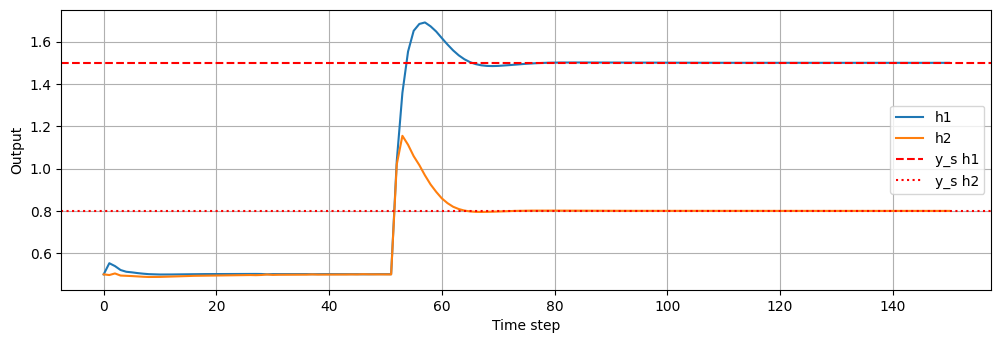

In [89]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.axhline(y=scaler.inverse_transform(y_s.value.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_s h1')
plt.axhline(y=scaler.inverse_transform(y_s.value.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_s h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [90]:
ys_sim[0,-1]

0.30112528000367395

In [91]:
from sklearn.metrics import mean_squared_error

# Descales ys_sim
ys_sim_descaled = scaler.inverse_transform(ys_sim.T).T

# Compute MSE for each output
mse_h1 = mean_squared_error(ys_sim_descaled[0], y_sim_descaled[0])
mse_h2 = mean_squared_error(ys_sim_descaled[1], y_sim_descaled[1])

print(f"MSE for h1: {mse_h1}")
print(f"MSE for h2: {mse_h2}")

MSE for h1: 0.006877963225640592
MSE for h2: 0.004207249314299733


In [92]:
from numpy import trapz

# Compute ISE for each output
ise_h1 = trapz((ys_sim_descaled[0] - y_sim_descaled[0])**2)
ise_h2 = trapz((ys_sim_descaled[1] - y_sim_descaled[1])**2)

print(f"ISE for h1: {ise_h1}")
print(f"ISE for h2: {ise_h2}")

ISE for h1: 1.0385724469114848
ISE for h2: 0.6352946464018876


In [93]:
z_sim[:nz, -1].flatten()-z_ref.value.flatten()

array([-2.55085658e-05, -1.10465898e-05,  6.23240741e-06, -1.27521161e-05,
       -1.06055332e-05,  2.01679531e-05,  7.52934046e-06, -2.22559706e-05,
       -1.05195812e-05, -2.64454288e-07])

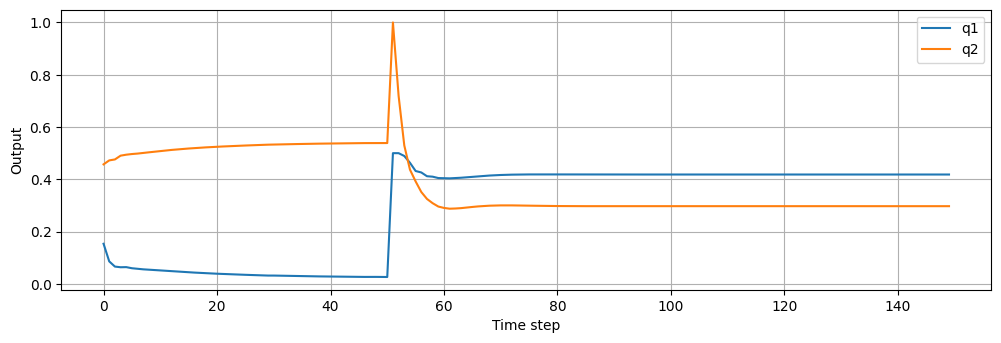

In [94]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

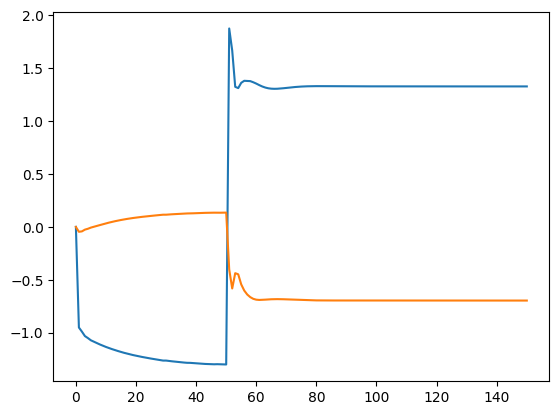

In [95]:
plt.plot(us_sim.T)

In [96]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[43.70867992 57.70980996]


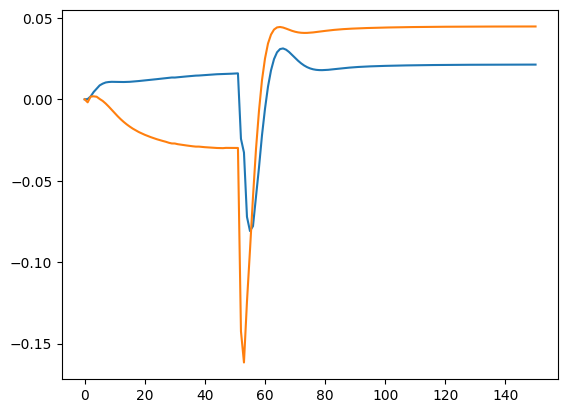

In [97]:
plt.plot(z_sim[nz:].T)

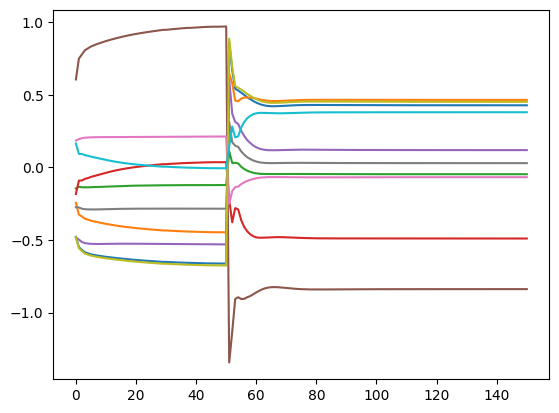

In [98]:
plt.plot(zs_sim.T)

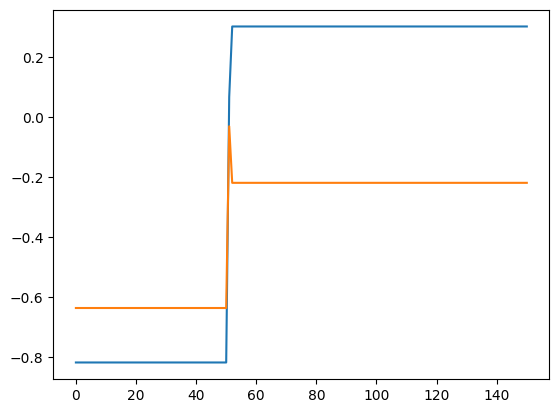

In [99]:
plt.plot(ys_sim.T)